In [11]:
import pandas as pd
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import roc_auc_score, confusion_matrix,accuracy_score, roc_curve, auc, precision_recall_curve

from torch.nn.utils.rnn import pad_sequence,pack_padded_sequence, pad_packed_sequence
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = 5,2

### Utility

In [12]:
def plot_attention(x, y, figname):
    if len(y) == 0: return
    
#     p0 = len(x)
#     for i in range(y.shape[0]):
#         if y[i] == y[i+1] and y[i+1] == y[i+2]:
#             p0 = i+2
#             break

#     x = x[:p0]
#     y = y[:p0]
#     print(x.shape, y.shape)
    fig, (ax,ax2) = plt.subplots(nrows=2, sharex=True)

    extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
    ax.imshow(y[np.newaxis,:], cmap="plasma", aspect="auto", extent=extent)
    ax.set_yticks([])
    ax.set_xlim(extent[0], extent[1])
    ax.set_xlabel("Time (by 4 hours)")
#     ax2.set_xlabel("Feature (index)")
    ax.set_ylabel("Weight")
    
    ax2.plot(x,y)
    ax2.set_xlabel("Time (by 4 hours)")
#     ax2.set_xlabel("Feature (index)")
    ax2.set_ylabel("Weight")
    plt.tight_layout()
    plt.savefig(figname)
    plt.show()
    
def plot_featuremap(x, y, figname):
    if len(y) == 0: return
    
#     p0 = len(x)
#     for i in range(y.shape[0]):
#         if y[i] == y[i+1] and y[i+1] == y[i+2]:
#             p0 = i+2
#             break

#     x = x[:p0]
#     y = y[:p0]
#     print(x.shape, y.shape)
    fig, (ax,ax2) = plt.subplots(nrows=2, sharex=True)

    extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
    ax.imshow(y[np.newaxis,:], cmap="plasma", aspect="auto", extent=extent)
    ax.set_yticks([])
    ax.set_xlim(extent[0], extent[1])
#     ax.set_xlabel("Time (by 4 hours)")
    ax2.set_xlabel("Feature (index)")
    ax.set_ylabel("Weight")
    
    ax2.plot(x,y)
#     ax2.set_xlabel("Time (by 4 hours)")
    ax2.set_xlabel("Feature (index)")
    ax2.set_ylabel("Weight")
    plt.tight_layout()
    plt.savefig(figname)
    plt.show()
    
    # print top 10 features
    top10=np.argsort(y)[-10:][::-1]
    
    print('top10 features are', top10)

In [13]:
import pickle
with open('MS_train.pt', 'rb') as f:
    train_data = pickle.load(f)
with open('MS_test.pt', 'rb') as f:
    test_data = pickle.load(f)

In [14]:
type(train_data[0]) ,len(train_data), len(test_data)

(tuple, 167, 132)

In [15]:
test_data[0][1][0].shape, test_data[0][1][1].shape, test_data[0][1][2].shape, test_data[0][1][3].shape, test_data[0][1][4].shape, \
test_data[0][1][5].shape, test_data[0][1][6].shape, test_data[0][1][7].shape, test_data[0][1][8].shape, test_data[0][1][9].shape

(torch.Size([3, 80]),
 torch.Size([6, 12]),
 torch.Size([1, 12]),
 torch.Size([256]),
 torch.Size([258]),
 torch.Size([258]),
 torch.Size([258]),
 torch.Size([258]),
 torch.Size([258]),
 torch.Size([21]))

In [16]:
from torch.utils.data import Dataset
class Covid_19(Dataset):
    def __init__(self,dataList):
        self.data_list = dataList
    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
#         print("idx",idx)
        ptid = self.data_list[idx][0]
        sample = self.data_list[idx][1]
        return sample
    

In [17]:
import torch
import torch.utils.data
import torchvision


class Sampler(torch.utils.data.sampler.Sampler):

    def __init__(self, dataset, indices=None, num_samples=None, callback_get_label=None):

        self.indices = list(range(len(dataset))) \
            if indices is None else indices
        self.callback_get_label = callback_get_label

        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        return dataset[idx][-1]
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [18]:
import torch.nn.functional as F

def pad_collate(batch):
    (pt_lab_batch, pt_vital_batch, pt_med_batch, 
     notes_embed_i, 
     T1_pre_embed_i, T1_post_embed_i, T2_embed_i, flair_embed_i, pd_embed_i,
     pt_demo_batch, 
     label_batch) = zip(*batch)
    
    pt_notes_embed_batch =torch.stack([item[3] for item in batch])
    pt_T1_pre_embed_batch =torch.stack([item[4] for item in batch])
    pt_T1_post_embed_batch =torch.stack([item[5] for item in batch])
    pt_T2_embed_batch =torch.stack([item[6] for item in batch])
    pt_flair_embed_batch =torch.stack([item[7] for item in batch])
    pt_pd_embed_batch =torch.stack([item[8] for item in batch])
    pt_demo_batch =torch.stack([item[9] for item in batch])
    label_batch =[item[10] for item in batch]

    max_lab = np.max(np.array([[DB.size(0),DB.size(1)]for DB in pt_lab_batch]),axis=0)
    max_vital = np.max(np.array([[DB.size(0),DB.size(1)]for DB in pt_vital_batch]),axis=0)
    max_med= np.max(np.array([[DB.size(0),DB.size(1)]for DB in pt_med_batch]),axis=0)

    lab_batch = torch.stack([
        F.pad(DB, [0, max_lab[1] - DB.size(1), 0, max_lab[0] - DB.size(0)])
        for DB in pt_lab_batch
        ])
    vital_batch = torch.stack([
        F.pad(DB, [0, max_vital[1] - DB.size(1), 0, max_vital[0] - DB.size(0)])
        for DB in pt_vital_batch
        ])
    med_batch = torch.stack([
        F.pad(DB, [0, max_med[1] - DB.size(1), 0, max_med[0] - DB.size(0)])
        for DB in pt_med_batch
        ])


    return lab_batch, vital_batch, med_batch, pt_notes_embed_batch, \
            pt_T1_pre_embed_batch, pt_T1_post_embed_batch, pt_T2_embed_batch, pt_flair_embed_batch, pt_pd_embed_batch, \
            pt_demo_batch, label_batch

In [19]:
import torch
import torch.utils.data
import torchvision


class Sampler(torch.utils.data.sampler.Sampler):

    def __init__(self, dataset, indices=None, num_samples=None, callback_get_label=None):

        self.indices = list(range(len(dataset))) \
            if indices is None else indices
        self.callback_get_label = callback_get_label

        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        return dataset[idx][-1]
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [20]:
from torch.utils.data import DataLoader

train_dataset=Covid_19(train_data)
validation_dataset = Covid_19(test_data)
trainSampler = Sampler(train_dataset)
dataloader = DataLoader(train_dataset, batch_size=24,
                        shuffle=False, num_workers=0,drop_last=True,collate_fn=pad_collate,sampler = trainSampler)
validation_loader = DataLoader(validation_dataset, batch_size=24,
                        shuffle=False, num_workers=0,drop_last=True,collate_fn=pad_collate)

In [21]:
class DBNet(nn.Module):
    def __init__(self):

        super(DBNet, self).__init__()
        
        ####vars to set
        dropout_GRU = 0.5
        hidden_size=512
        no_GRU_layers=4
        output_size = 2
        GRU_input_size = 258 
        no_hops = 8
        
        
        ###(kernel_size,in_channel,out_channel, stride,pad)  
        lab_kernels = [(7,1,8,2,0),(4,8,8,2,0),(3,8,1,2,1)]
        vital_kernels =  [(3,1,8,2,0),(2,8,1,2,1)]
        medAdmin_kernels = [(3,1,8,2,0),(2,8,1,2,1)]

        self.lab_layers = nn.ModuleList()
        self.vital_layers = nn.ModuleList()
        self.medAdmin_layers = nn.ModuleList()

        self.make_encoder_block(lab_kernels,self.lab_layers)
        self.make_encoder_block(vital_kernels,self.vital_layers)
        self.make_encoder_block(medAdmin_kernels,self.medAdmin_layers)

        self.GRU = nn.GRU(GRU_input_size, hidden_size, no_GRU_layers, dropout=dropout_GRU,
                                         batch_first=True, bias=False, bidirectional=True)
        self.GRU_dropout = nn.Dropout(p=dropout_GRU)
        self.conv_att = nn.Conv1d(in_channels=1, out_channels=no_hops, kernel_size=hidden_size * 2, stride=1)

        self.linear = nn.Linear(hidden_size * 2 * no_hops + 21, output_size, bias=False)


        self.softmax = nn.Softmax(dim=1)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Hardtanh(0, 1)
        self.init_weights()
        self.no_hops = no_hops
        self.hidden_size = hidden_size 
        self.output_size = output_size
        self.no_GRU_layers = no_GRU_layers

        
    def make_encoder_block(self,kernel_list,layer_list):
        for i,kernels in enumerate(kernel_list):
            layer_list.append(nn.Conv1d(in_channels=kernels[1],
                                        out_channels=kernels[2],
                                        kernel_size=kernels[0],
                                        stride=kernels[3],
                                        padding=kernels[4]))
            if i <len(layer_list)-1:
                layer_list.append(nn.ReLU())
            layer_list.append(nn.Dropout(p=0.3))
        layer_list.append(nn.AdaptiveAvgPool1d(1))

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Conv1d):
                torch.nn.init.xavier_uniform_(m.weight)


    def lab_encoder(self, lab):
        encoded_DAMs=[]
        for i in range(lab.size(1)):
            for j,layer in enumerate(self.lab_layers):
                if j==0:
                    out = layer(torch.unsqueeze(lab[:,i],dim=1))
                else:
                    out =layer(out)
            encoded_DAMs.append(out)
        # ------------ plot attention weights
#         print('Attension weights is encoded_DAMs is', len(encoded_DAMs))
#         x = np.array(range(len(encoded_DAMs)), dtype=int)
#         y = np.array([[i[0][0][0].item() for i in encoded_DAMs]]).squeeze()
#         plot_attention(x, y, 'time-lab.pdf')
        # -----------------------------------
        encoded_DAMs = torch.stack(encoded_DAMs)
        encoded_DAMs = torch.squeeze(encoded_DAMs, dim=3)
        encoded_DAMs = torch.transpose(encoded_DAMs, 0, 1)
        encoded_DAMs = torch.transpose(encoded_DAMs, 1, 2)
        encoded_DAMs = self.tanh(encoded_DAMs)
        encoded_DAMs = torch.bmm(encoded_DAMs, lab)
        encoded_DAMs = torch.squeeze(encoded_DAMs, dim=1)
        # ------------ plot feature weights
#         print('Feature weights is encoded_DAMs is', len(encoded_DAMs), encoded_DAMs.shape)
#         x = np.array(range(encoded_DAMs.shape[1]), dtype=int)
#         y = encoded_DAMs[0,:].cpu().detach().numpy()
#         plot_featuremap(x, y, 'feature_lab.pdf')
        # -----------------------------------
        return encoded_DAMs
    
    def vital_encoder(self, vital):
        encoded_DPCs=[]
        for i in range(vital.size(1)):
            for j,layer in enumerate(self.vital_layers):
                if j==0:
                    out = layer(torch.unsqueeze(vital[:,i],dim=1))
                else:
                    out =layer(out)
            encoded_DPCs.append(out)
        # ------------ plot attention weights
#         print('Attension weights is encoded_DPCs is', len(encoded_DPCs))
#         x = np.array(range(len(encoded_DPCs)), dtype=int)
#         y = np.array([[i[0][0][0].item() for i in encoded_DPCs]]).squeeze()
#         plot_attention(x, y, 'time-diag.pdf')
        # -----------------------------------    
        encoded_DPCs = torch.stack(encoded_DPCs)
        encoded_DPCs = torch.squeeze(encoded_DPCs, dim=3)
        encoded_DPCs =  torch.transpose(encoded_DPCs, 0, 1)
        encoded_DPCs = torch.transpose(encoded_DPCs, 1, 2)
        encoded_DPCs = self.tanh(encoded_DPCs)
        encoded_DPCs = torch.bmm(encoded_DPCs, vital)
        encoded_DPCs = torch.squeeze(encoded_DPCs, dim=1)
        # ------------ plot feature weights
#         print('Feature weights is encoded_DPCs is', len(encoded_DPCs), encoded_DPCs.shape)
#         x = np.array(range(encoded_DPCs.shape[1]), dtype=int)
#         y = encoded_DPCs[0,:].cpu().detach().numpy()
#         plot_featuremap(x, y, 'feature-diag.pdf')
        # -----------------------------------
        return encoded_DPCs
    
    def medAdmin_encoder(self, medAdmin):
        encoded_medAdmins = []
        for i in range(medAdmin.size(1)):
            for j,layer in enumerate(self.medAdmin_layers):
                if j==0:
                    out = layer(torch.unsqueeze(medAdmin[:,i],dim=1))
                else:
                    out =layer(out)
            encoded_medAdmins.append(out)
        # ------------ plot attention weights
#         print('Attension weights is encoded_medAdmins is', len(encoded_medAdmins))
#         x = np.array(range(len(encoded_medAdmins)), dtype=int)
#         y = np.array([[i[0][0][0].item() for i in encoded_medAdmins]]).squeeze()
#         plot_attention(x, y,'time-medAdmin.pdf')
        # ----------------------------------- 
        encoded_medAdmins = torch.stack(encoded_medAdmins)
        encoded_medAdmins = torch.squeeze(encoded_medAdmins, dim=3)
        encoded_medAdmins =  torch.transpose(encoded_medAdmins, 0, 1)
        encoded_medAdmins = torch.transpose(encoded_medAdmins, 1, 2)
        encoded_medAdmins = self.tanh(encoded_medAdmins)
        encoded_medAdmins = torch.bmm(encoded_medAdmins, medAdmin)
        encoded_medAdmins = torch.squeeze(encoded_medAdmins, dim=1)
        # ------------ plot feature weights
#         print('Feature weights is encoded_medAdmins is', len(encoded_medAdmins), encoded_medAdmins.shape)
#         x = np.array(range(encoded_medAdmins.shape[1]), dtype=int)
#         y = encoded_medAdmins[0,:].cpu().detach().numpy()
#         plot_featuremap(x, y, 'feature-medAdmins.pdf')
        # -----------------------------------
        return encoded_medAdmins
    
    
    def init_GRU(self, batch_size):
        self.weight = next(self.parameters()).data
        init_state = (Variable(self.weight.new(self.no_GRU_layers * 2, batch_size, self.hidden_size).zero_()))
        return init_state

    
    def GRU_Decoder(self, inputs,batch_size):
        inputs = self.GRU_dropout(inputs)
        init_state = self.init_GRU(batch_size)
        outputs, states = self.GRU(inputs, init_state)
        return outputs,states
    

    def Self_Attention(self, hidden_states, batch_size):
        Attention_list = []
        for i in range(5):
            m1 = self.conv_att(torch.unsqueeze(hidden_states[:, i], dim=1))
            Attention_list.append(torch.squeeze(m1, dim=2))
        Attention_list = torch.stack(Attention_list, dim=2)
        Attention_hops = []
        for i in range(self.no_hops):
            attention_single = self.softmax(Attention_list[:, i])
            Attention_hops.append(attention_single)
        Attention_hops = torch.stack(Attention_hops, dim=1)
        output = torch.bmm(Attention_hops, hidden_states)
        output = output.view(batch_size, -1)
        return output

    def forward(self, lab, vital, med, note_embed, MRI_embed_1, MRI_embed_2,MRI_embed_3,MRI_embed_4,MRI_embed_5, pt_demo, batch_size):
        encoded_labs = self.lab_encoder(lab)
        encoded_vital = self.vital_encoder(vital)
        encoded_medAdmins = self.medAdmin_encoder(med)

        GRU_input=pad_sequence([
#                                 torch.transpose(encoded_labs, 0, 1),
#                                 torch.transpose(encoded_vital, 0, 1),
#                                 torch.transpose(encoded_medAdmins, 0, 1), 
#                                 torch.transpose(note_embed, 0, 1), 
                                torch.transpose(MRI_embed_1, 0, 1), 
                                torch.transpose(MRI_embed_2, 0, 1), 
                                torch.transpose(MRI_embed_3, 0, 1), 
                                torch.transpose(MRI_embed_4, 0, 1), 
                                torch.transpose(MRI_embed_5, 0, 1), 
                               ])
#         print(GRU_input.shape)# torch.Size([376, 5, 24])

        GRU_input = torch.transpose(GRU_input, 0, 2)
#         print(GRU_input.shape) # torch.Size([24, 5, 376])
#         input("Stop here.")
        outputs_GRU,states_GRU = self.GRU_Decoder(GRU_input, batch_size)
        GRU_out = self.Self_Attention(outputs_GRU, batch_size)
        context = torch.cat((GRU_out, pt_demo), 1)
        linear_y = self.linear(context)
        out = self.sigmoid(linear_y)
        return linear_y,out

In [22]:
def evaluate(y_test, preds):
    roc_auc_macro = roc_auc_score(y_test, preds, average='macro')
    roc_auc_micro = roc_auc_score(y_test, preds, average='micro')
#     f1_macro= f1_score(y_test, preds, average='binary')
#     f1_micro= f1_score(y_test, preds, average='micro')      
    lr_precision, lr_recall, thresholds = precision_recall_curve(y_test, preds)
#     auprc = auc(lr_recall, lr_precision)
    auprc = average_precision_score(y_test, preds)
    f1_binary_best, f1_macro_best, f1_micro_best, thr_best = float('-inf'),float('-inf'), float('-inf'), 0
    for thr in thresholds:
        f1_binary, f1_macro, f1_micro = evaluate2(y_test, preds, thr)
#         print(f1_macro, f1_micro, f1_macro_best, f1_micro_best)
        if f1_binary > f1_binary_best or f1_macro > f1_macro_best or f1_micro > f1_micro_best:
            f1_binary_best = f1_binary
            f1_macro_best = f1_macro
            f1_micro_best = f1_micro
            thr_best = thr
    print("AUC-Macro: {}, \n AUC-Micro: {}, \n AUPRC: {}, \n F1-Binary: {}, \n F1-Macro: {}, \n F1-Micro: {}".format(roc_auc_macro,roc_auc_micro, auprc, f1_binary_best, f1_macro_best, f1_micro_best)) # F1, F1))
       
def evaluate2(y_test, preds, thr):  
    f1_binary= f1_score(y_test, preds>thr, average='binary')# 'macro')
    f1_macro= f1_score(y_test, preds>thr, average='macro')
    f1_micro= f1_score(y_test, preds>thr, average='micro') 
    return f1_binary, f1_macro, f1_micro


### Train

In [27]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
import time
EPOCHS = 500
batch_size=24
model=DBNet()
model = model.to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

print("Starting Training of {} model")
# with open('performance.txt', 'a+') as f:
#     f.write("Starting Training of {} model\n")
epoch_times = []
best_AUC=0
for epoch in range(1,EPOCHS+1):
    start_time = time.time()
    avg_loss = 0.
    counter = 0
    correct = 0
    total = 0
    model.train()
    for sample in dataloader:
        lab, vital, medAdmin, note_embed, MRI_embed_1, MRI_embed_2, MRI_embed_3, MRI_embed_4, MRI_embed_5, pt_demo,label = sample
        model.zero_grad()
        one_hot_label = np.eye(2)[np.array(label,dtype="int")]
        one_hot_label = torch.tensor(one_hot_label)
        label= torch.tensor(label).type(torch.long)
        lab = lab.to(device)
        vital = vital.to(device)
        medAdmin = medAdmin.to(device)
        note_embed = note_embed.to(device)
        MRI_embed_1 = MRI_embed_1.to(device)
        MRI_embed_2 = MRI_embed_2.to(device)
        MRI_embed_3 = MRI_embed_3.to(device)
        MRI_embed_4 = MRI_embed_4.to(device)
        MRI_embed_5 = MRI_embed_5.to(device)
        pt_demo = pt_demo.to(device)
        counter += 1
        out,predict=model(lab, vital, medAdmin, note_embed, MRI_embed_1, MRI_embed_2, MRI_embed_3, MRI_embed_4, MRI_embed_5, pt_demo,batch_size)
        one_hot_label = one_hot_label.type_as(out).to(device)
        loss = criterion(out, one_hot_label)
        _, predicted = torch.max(predict.detach().cpu(), 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
    current_time = time.time()
    print("Epoch {}/{} Done, Total Loss: {}, Accuracy : {} ".format(epoch, EPOCHS, avg_loss/len(dataloader),correct/total))
    print("Total Time Elapsed: {} seconds".format(str(current_time-start_time)))
#     with open('performance.txt', 'a+') as f:
#         f.write("Epoch {}/{} Done, Total Loss: {}, Accuracy : {} \n".format(epoch, EPOCHS, avg_loss/len(dataloader),correct/total))
#         f.write("Total Time Elapsed: {} seconds\n".format(str(current_time-start_time)))
    epoch_times.append(current_time-start_time)
    val_total=0
    val_correct = 0
    model.eval()
    predicted_list=[]
    prediction_probablity=[]
    label_list = []
    for sample in validation_loader:
        lab,vital, medAdmin, note_embed, MRI_embed_1, MRI_embed_2, MRI_embed_3, MRI_embed_4, MRI_embed_5, pt_demo,label = sample
        #model.zero_grad()
        label= torch.tensor(label).type(torch.long)
        lab = lab.to(device)
        vital = vital.to(device)
        medAdmin = medAdmin.to(device)
        note_embed = note_embed.to(device)
        MRI_embed_1 = MRI_embed_1.to(device)
        MRI_embed_2 = MRI_embed_2.to(device)
        MRI_embed_3 = MRI_embed_3.to(device)
        MRI_embed_4 = MRI_embed_4.to(device)
        MRI_embed_5 = MRI_embed_5.to(device)
        pt_demo = pt_demo.to(device)
        out,predict=model(lab,vital, medAdmin, note_embed, MRI_embed_1, MRI_embed_2, MRI_embed_3, MRI_embed_4, MRI_embed_5, pt_demo,batch_size)
        _, predicted = torch.max(predict.detach().cpu(), 1)
        predicted_list.append(predicted.cpu().numpy())
        predicted_2 = predict.detach().cpu().numpy()
        prediction_prob = predicted_2[:,1]
        prediction_probablity.append(prediction_prob)
        label_list.append(label.cpu().numpy())
        val_total += label.size(0)
        val_correct += (predicted == label).sum().item()
    Accuracy = val_correct/val_total
    y=np.array(label_list)
    false_positive_rate, recall, thresholds = roc_curve(y.flatten(), np.array(prediction_probablity).flatten())
    roc_auc = auc(false_positive_rate, recall)
    if roc_auc > best_AUC:
        best_AUC = roc_auc
        torch.save(model.state_dict(), "Models_saved_DBNet_onlyMRI/State_checkpoints_{}.thr".format(epoch))
        torch.save(model, "Models_saved_DBNet_onlyMRI/Model_checkpoints_{}.thr".format(epoch))
    print("AUC: {} , Accuracy: {}".format(roc_auc,Accuracy))
#     with open('performance.txt', 'a+') as f:
#         f.write("AUC: {} , Accuracy: {}\n".format(roc_auc,Accuracy))
print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
# with open('performance.txt', 'a+') as f:
#     f.write("Total Training Time: {} seconds\n".format(str(sum(epoch_times))))


Starting Training of {} model
Epoch 1/500 Done, Total Loss: 1.8013656636079152, Accuracy : 0.5208333333333334 
Total Time Elapsed: 0.32744622230529785 seconds
AUC: 0.5479600694444444 , Accuracy: 0.7833333333333333
Epoch 2/500 Done, Total Loss: 0.9901060958703359, Accuracy : 0.5347222222222222 
Total Time Elapsed: 0.28449058532714844 seconds
AUC: 0.5440538194444444 , Accuracy: 0.775
Epoch 3/500 Done, Total Loss: 0.7571287155151367, Accuracy : 0.5208333333333334 
Total Time Elapsed: 0.31952762603759766 seconds
AUC: 0.48849826388888884 , Accuracy: 0.3333333333333333
Epoch 4/500 Done, Total Loss: 0.7575337191422781, Accuracy : 0.4652777777777778 
Total Time Elapsed: 0.27787160873413086 seconds
AUC: 0.5753038194444444 , Accuracy: 0.7416666666666667
Epoch 5/500 Done, Total Loss: 0.6814868847529093, Accuracy : 0.5972222222222222 
Total Time Elapsed: 0.33709168434143066 seconds
AUC: 0.4932725694444445 , Accuracy: 0.31666666666666665
Epoch 6/500 Done, Total Loss: 0.7229275604089102, Accuracy : 

AUC: 0.5894097222222222 , Accuracy: 0.725
Epoch 48/500 Done, Total Loss: 0.6988543470700582, Accuracy : 0.5486111111111112 
Total Time Elapsed: 0.5790309906005859 seconds
AUC: 0.5190972222222222 , Accuracy: 0.3416666666666667
Epoch 49/500 Done, Total Loss: 0.6738601326942444, Accuracy : 0.5902777777777778 
Total Time Elapsed: 0.5967278480529785 seconds
AUC: 0.5826822916666666 , Accuracy: 0.7416666666666667
Epoch 50/500 Done, Total Loss: 0.6856553455193838, Accuracy : 0.5138888888888888 
Total Time Elapsed: 0.541175127029419 seconds
AUC: 0.5655381944444444 , Accuracy: 0.5333333333333333
Epoch 51/500 Done, Total Loss: 0.6407236059506735, Accuracy : 0.6666666666666666 
Total Time Elapsed: 0.4451286792755127 seconds
AUC: 0.5453559027777778 , Accuracy: 0.5166666666666667
Epoch 52/500 Done, Total Loss: 0.6750283241271973, Accuracy : 0.6111111111111112 
Total Time Elapsed: 0.6091971397399902 seconds
AUC: 0.5855034722222222 , Accuracy: 0.775
Epoch 53/500 Done, Total Loss: 0.6549602150917053, A

AUC: 0.5842013888888888 , Accuracy: 0.775
Epoch 94/500 Done, Total Loss: 0.6548104087511698, Accuracy : 0.5833333333333334 
Total Time Elapsed: 0.6360218524932861 seconds
AUC: 0.5835503472222222 , Accuracy: 0.5416666666666666
Epoch 95/500 Done, Total Loss: 0.7060473561286926, Accuracy : 0.5208333333333334 
Total Time Elapsed: 0.6126067638397217 seconds
AUC: 0.5768229166666666 , Accuracy: 0.5583333333333333
Epoch 96/500 Done, Total Loss: 0.655538946390152, Accuracy : 0.625 
Total Time Elapsed: 0.6024577617645264 seconds
AUC: 0.5965711805555555 , Accuracy: 0.775
Epoch 97/500 Done, Total Loss: 0.6651281317075094, Accuracy : 0.6666666666666666 
Total Time Elapsed: 0.6382148265838623 seconds
AUC: 0.578342013888889 , Accuracy: 0.5583333333333333
Epoch 98/500 Done, Total Loss: 0.6698128879070282, Accuracy : 0.6458333333333334 
Total Time Elapsed: 0.6516311168670654 seconds
AUC: 0.5802951388888888 , Accuracy: 0.5583333333333333
Epoch 99/500 Done, Total Loss: 0.6748881340026855, Accuracy : 0.59

Epoch 140/500 Done, Total Loss: 0.6188088059425354, Accuracy : 0.6180555555555556 
Total Time Elapsed: 0.6684980392456055 seconds
AUC: 0.593967013888889 , Accuracy: 0.49166666666666664
Epoch 141/500 Done, Total Loss: 0.5991833309332529, Accuracy : 0.6944444444444444 
Total Time Elapsed: 0.6652090549468994 seconds
AUC: 0.5930989583333334 , Accuracy: 0.5
Epoch 142/500 Done, Total Loss: 0.6581160426139832, Accuracy : 0.5416666666666666 
Total Time Elapsed: 0.629619836807251 seconds
AUC: 0.6247829861111112 , Accuracy: 0.75
Epoch 143/500 Done, Total Loss: 0.6377470890680949, Accuracy : 0.6180555555555556 
Total Time Elapsed: 0.6079020500183105 seconds
AUC: 0.6182725694444443 , Accuracy: 0.6666666666666666
Epoch 144/500 Done, Total Loss: 0.6574416955312093, Accuracy : 0.625 
Total Time Elapsed: 0.6207027435302734 seconds
AUC: 0.5865885416666666 , Accuracy: 0.5166666666666667
Epoch 145/500 Done, Total Loss: 0.6634423434734344, Accuracy : 0.6527777777777778 
Total Time Elapsed: 0.5800716876983

AUC: 0.5815972222222222 , Accuracy: 0.5583333333333333
Epoch 187/500 Done, Total Loss: 0.6443853676319122, Accuracy : 0.6041666666666666 
Total Time Elapsed: 0.6260650157928467 seconds
AUC: 0.5965711805555556 , Accuracy: 0.6666666666666666
Epoch 188/500 Done, Total Loss: 0.6481307943662008, Accuracy : 0.5972222222222222 
Total Time Elapsed: 0.5360598564147949 seconds
AUC: 0.6002604166666666 , Accuracy: 0.7583333333333333
Epoch 189/500 Done, Total Loss: 0.6168426275253296, Accuracy : 0.625 
Total Time Elapsed: 0.6283836364746094 seconds
AUC: 0.6019965277777779 , Accuracy: 0.75
Epoch 190/500 Done, Total Loss: 0.6644531091054281, Accuracy : 0.5763888888888888 
Total Time Elapsed: 0.5603983402252197 seconds
AUC: 0.6078559027777778 , Accuracy: 0.6666666666666666
Epoch 191/500 Done, Total Loss: 0.6062312126159668, Accuracy : 0.625 
Total Time Elapsed: 0.5525186061859131 seconds
AUC: 0.6176215277777778 , Accuracy: 0.75
Epoch 192/500 Done, Total Loss: 0.6462567448616028, Accuracy : 0.5625 
Tot

AUC: 0.570529513888889 , Accuracy: 0.4166666666666667
Epoch 234/500 Done, Total Loss: 0.6351239581902822, Accuracy : 0.6180555555555556 
Total Time Elapsed: 0.5571904182434082 seconds
AUC: 0.5948350694444444 , Accuracy: 0.55
Epoch 235/500 Done, Total Loss: 0.6194270849227905, Accuracy : 0.6180555555555556 
Total Time Elapsed: 0.5464181900024414 seconds
AUC: 0.6217447916666667 , Accuracy: 0.6666666666666666
Epoch 236/500 Done, Total Loss: 0.6695833404858907, Accuracy : 0.5902777777777778 
Total Time Elapsed: 0.5730078220367432 seconds
AUC: 0.5983072916666666 , Accuracy: 0.55
Epoch 237/500 Done, Total Loss: 0.7034818530082703, Accuracy : 0.5625 
Total Time Elapsed: 0.5175938606262207 seconds
AUC: 0.6226128472222222 , Accuracy: 0.775
Epoch 238/500 Done, Total Loss: 0.6310196121533712, Accuracy : 0.6111111111111112 
Total Time Elapsed: 0.6025662422180176 seconds
AUC: 0.5980902777777778 , Accuracy: 0.5333333333333333
Epoch 239/500 Done, Total Loss: 0.6393950780232748, Accuracy : 0.604166666

Epoch 281/500 Done, Total Loss: 0.6859301030635834, Accuracy : 0.5347222222222222 
Total Time Elapsed: 0.6519467830657959 seconds
AUC: 0.6204427083333334 , Accuracy: 0.775
Epoch 282/500 Done, Total Loss: 0.7314492166042328, Accuracy : 0.5 
Total Time Elapsed: 0.5737004280090332 seconds
AUC: 0.552734375 , Accuracy: 0.36666666666666664
Epoch 283/500 Done, Total Loss: 0.6759348114331564, Accuracy : 0.5694444444444444 
Total Time Elapsed: 0.6007962226867676 seconds
AUC: 0.619357638888889 , Accuracy: 0.775
Epoch 284/500 Done, Total Loss: 0.6935761769612631, Accuracy : 0.5555555555555556 
Total Time Elapsed: 0.5906119346618652 seconds
AUC: 0.5828993055555556 , Accuracy: 0.4166666666666667
Epoch 285/500 Done, Total Loss: 0.661980003118515, Accuracy : 0.5833333333333334 
Total Time Elapsed: 0.573430061340332 seconds
AUC: 0.6098090277777777 , Accuracy: 0.6166666666666667
Epoch 286/500 Done, Total Loss: 0.6492611269156138, Accuracy : 0.5972222222222222 
Total Time Elapsed: 0.5635049343109131 sec

AUC: 0.6284722222222222 , Accuracy: 0.75
Epoch 328/500 Done, Total Loss: 0.6489337682723999, Accuracy : 0.5555555555555556 
Total Time Elapsed: 0.625575065612793 seconds
AUC: 0.5857204861111112 , Accuracy: 0.525
Epoch 329/500 Done, Total Loss: 0.6698821683724722, Accuracy : 0.5347222222222222 
Total Time Elapsed: 0.5508327484130859 seconds
AUC: 0.6223958333333334 , Accuracy: 0.7416666666666667
Epoch 330/500 Done, Total Loss: 0.6442723870277405, Accuracy : 0.5972222222222222 
Total Time Elapsed: 0.5026144981384277 seconds
AUC: 0.6056857638888888 , Accuracy: 0.5333333333333333
Epoch 331/500 Done, Total Loss: 0.6796006560325623, Accuracy : 0.5694444444444444 
Total Time Elapsed: 0.6283819675445557 seconds
AUC: 0.6243489583333334 , Accuracy: 0.75
Epoch 332/500 Done, Total Loss: 0.6829814414183298, Accuracy : 0.5763888888888888 
Total Time Elapsed: 0.6161148548126221 seconds
AUC: 0.5631510416666667 , Accuracy: 0.36666666666666664
Epoch 333/500 Done, Total Loss: 0.673883467912674, Accuracy :

AUC: 0.5501302083333333 , Accuracy: 0.4166666666666667
Epoch 375/500 Done, Total Loss: 0.6460012396176656, Accuracy : 0.5763888888888888 
Total Time Elapsed: 0.6190705299377441 seconds
AUC: 0.5937500000000001 , Accuracy: 0.775
Epoch 376/500 Done, Total Loss: 0.662187933921814, Accuracy : 0.5486111111111112 
Total Time Elapsed: 0.6723699569702148 seconds
AUC: 0.6137152777777778 , Accuracy: 0.6
Epoch 377/500 Done, Total Loss: 0.6246033410231272, Accuracy : 0.625 
Total Time Elapsed: 0.563194990158081 seconds
AUC: 0.6145833333333333 , Accuracy: 0.7583333333333333
Epoch 378/500 Done, Total Loss: 0.6448644797007242, Accuracy : 0.5625 
Total Time Elapsed: 0.5847532749176025 seconds
AUC: 0.6187065972222223 , Accuracy: 0.6
Epoch 379/500 Done, Total Loss: 0.6329219142595927, Accuracy : 0.6111111111111112 
Total Time Elapsed: 0.5441749095916748 seconds
AUC: 0.6236979166666666 , Accuracy: 0.6
Epoch 380/500 Done, Total Loss: 0.5946811536947886, Accuracy : 0.6736111111111112 
Total Time Elapsed: 0.

AUC: 0.5872395833333334 , Accuracy: 0.5333333333333333
Epoch 422/500 Done, Total Loss: 0.6769442756970724, Accuracy : 0.4930555555555556 
Total Time Elapsed: 0.6107690334320068 seconds
AUC: 0.616970486111111 , Accuracy: 0.7416666666666667
Epoch 423/500 Done, Total Loss: 0.6074060201644897, Accuracy : 0.625 
Total Time Elapsed: 0.6337277889251709 seconds
AUC: 0.6063368055555556 , Accuracy: 0.6
Epoch 424/500 Done, Total Loss: 0.5970824658870697, Accuracy : 0.6319444444444444 
Total Time Elapsed: 0.6632614135742188 seconds
AUC: 0.6197916666666667 , Accuracy: 0.7416666666666667
Epoch 425/500 Done, Total Loss: 0.6832821667194366, Accuracy : 0.5277777777777778 
Total Time Elapsed: 0.594984769821167 seconds
AUC: 0.6247829861111112 , Accuracy: 0.7583333333333333
Epoch 426/500 Done, Total Loss: 0.6315111517906189, Accuracy : 0.6527777777777778 
Total Time Elapsed: 0.5287816524505615 seconds
AUC: 0.5726996527777778 , Accuracy: 0.525
Epoch 427/500 Done, Total Loss: 0.6215587755044302, Accuracy : 

AUC: 0.5870225694444444 , Accuracy: 0.525
Epoch 469/500 Done, Total Loss: 0.6523386836051941, Accuracy : 0.5763888888888888 
Total Time Elapsed: 0.621544599533081 seconds
AUC: 0.5857204861111112 , Accuracy: 0.525
Epoch 470/500 Done, Total Loss: 0.6232736706733704, Accuracy : 0.5972222222222222 
Total Time Elapsed: 0.615687370300293 seconds
AUC: 0.6165364583333334 , Accuracy: 0.7416666666666667
Epoch 471/500 Done, Total Loss: 0.6634499828020731, Accuracy : 0.5416666666666666 
Total Time Elapsed: 0.5997645854949951 seconds
AUC: 0.6217447916666666 , Accuracy: 0.6166666666666667
Epoch 472/500 Done, Total Loss: 0.6723571022351583, Accuracy : 0.5625 
Total Time Elapsed: 0.5956382751464844 seconds
AUC: 0.6195746527777778 , Accuracy: 0.6166666666666667
Epoch 473/500 Done, Total Loss: 0.6573589344819387, Accuracy : 0.5833333333333334 
Total Time Elapsed: 0.6301183700561523 seconds
AUC: 0.6202256944444444 , Accuracy: 0.6166666666666667
Epoch 474/500 Done, Total Loss: 0.6465049783388773, Accuracy

In [28]:
best_AUC

0.6338975694444444

#### directly load best model

In [29]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
import time
model=DBNet()
model.load_state_dict(torch.load("Models_saved_DBNet_onlyMRI/State_checkpoints_{}.thr".format(242)))
#torch.save(model, "sssssssss/Model_checkpoints_{}.thr".format(epoch))
model = model.to(device)

val_total=0
val_correct = 0
model.eval()
predicted_list=[]
prediction_probablity=[]
label_list = []
for sample in tqdm(validation_loader):
    lab,vital, medAdmin, note_embed, MRI_embed_1, MRI_embed_2, MRI_embed_3, MRI_embed_4, MRI_embed_5, pt_demo,label = sample
    #model.zero_grad()
    label= torch.tensor(label).type(torch.long)
    lab = lab.to(device)
    vital = vital.to(device)
    medAdmin = medAdmin.to(device)
    note_embed = note_embed.to(device)
    MRI_embed_1 = MRI_embed_1.to(device)
    MRI_embed_2 = MRI_embed_2.to(device)
    MRI_embed_3 = MRI_embed_3.to(device)
    MRI_embed_4 = MRI_embed_4.to(device)
    MRI_embed_5 = MRI_embed_5.to(device)
    pt_demo = pt_demo.to(device)
    out,predict=model(lab,vital, medAdmin, note_embed, MRI_embed_1, MRI_embed_2, MRI_embed_3, MRI_embed_4, MRI_embed_5, pt_demo,batch_size)
#     print(predict)
    _, predicted = torch.max(predict.detach().cpu(), 1)
#     print(predicted)
    predicted_list.append(predicted.cpu().numpy())
#     print(predicted_list)
    predicted_2 = predict.detach().cpu().numpy()
#     print(predicted_2)
    prediction_prob = predicted_2[:,1]
#     print(prediction_prob)
    prediction_probablity.append(prediction_prob)
    label_list.append(label.cpu().numpy())
#     print(label_list)
    val_total += label.size(0)
    val_correct += (predicted == label).sum().item()
Accuracy = val_correct/val_total
y=np.array(label_list)
false_positive_rate, recall, thresholds = roc_curve(y.flatten(), np.array(prediction_probablity).flatten())
roc_auc = auc(false_positive_rate, recall)
lr_precision, lr_recall, _ = precision_recall_curve(y.flatten(), np.array(prediction_probablity).flatten())
# auprc = auc(lr_recall, lr_precision)

auprc = average_precision_score(y.flatten(), np.array(prediction_probablity).flatten())
print("AUC: {} , Accuracy: {}, AUPRC: {}".format(roc_auc,Accuracy,auprc))


100%|██████████| 5/5 [00:00<00:00, 38.11it/s]

AUC: 0.6338975694444444 , Accuracy: 0.775, AUPRC: 0.3331645581669193


AUC:  0.9184027777777778 AUPRC:  0.8634331755536364
Best Threshold=0.855082, G-Mean=0.880
TN:  94 , FP:  2 , FN: 6 , TP: 18
==> Sensitivity (Recall, TPR): 0.750
==> Specifity: 0.979
==> Positive Predictive Value (PPV) (Precision): 0.900
==> Negative Predictive Value (NPV): 0.940
==> Accuracy: 0.933
==> F1 score: 0.818


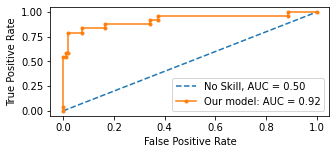

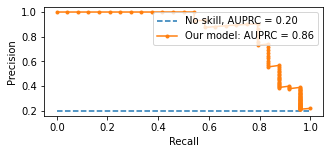

In [62]:
print_metrics(y.flatten(), np.array(prediction_probablity).flatten())

In [36]:
from sklearn.metrics import roc_curve, confusion_matrix , auc, precision_recall_curve, average_precision_score
from sklearn import metrics

def print_metrics(y_true, y_pred):
    import matplotlib.pyplot as plt
    
    false_positive_rate, recall, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(false_positive_rate, recall)
    auprc = average_precision_score(y_true, y_pred)
    print('AUC: ',roc_auc, "AUPRC: ", auprc)


    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)

    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))


    tn, fp, fn, tp = confusion_matrix(y_true, y_pred > thresholds[ix]).ravel()
    print('TN: ', tn, ", FP: ",fp, ", FN:", fn, ", TP:", tp)
    print("==> Sensitivity (Recall, TPR): %.3f"%(tp/(tp+fn)))
    print("==> Specifity: %.3f"%(tn/(tn+fp)))
    print("==> Positive Predictive Value (PPV) (Precision): %.3f"%(tp / (tp + fp)))
    print("==> Negative Predictive Value (NPV): %.3f"%(tn / (tn + fn)))
    print("==> Accuracy: %.3f"%((tp+tn)/(tn+ fp+ fn+tp)))
    print("==> F1 score: %.3f"%((2*tp)/(2*tp + fp + fn)))
    
    # method I: plt
#     fpr, tpr, _ = roc_curve(y_true, y_pred)
#     plt.title('Receiver Operating Characteristic')
#     plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
#     plt.legend(loc = 'lower right')
#     plt.plot([0, 1], [0, 1],'r--')
#     plt.xlim([0, 1])
#     plt.ylim([0, 1])
#     plt.ylabel('True Positive Rate')
#     plt.xlabel('False Positive Rate')
#     plt.show()
    ns_probs = [0 for _ in range(len(y_true))]
    
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_true, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_true, y_pred)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill, AUC = %0.2f' % 0.5)
    plt.plot(lr_fpr, lr_tpr, marker='.', label = 'Our model: AUC = %0.2f' % roc_auc)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    
    lr_precision, lr_recall, _ = precision_recall_curve(y_true, y_pred)
    lr_auc = auc(lr_recall, lr_precision)
    # summarize scores
#     print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
    # plot the precision-recall curves
    y_true = np.array(y_true)
    no_skill = len(y_true[y_true==1]) / len(y_true)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No skill, AUPRC = %0.2f' % no_skill)
    plt.plot(lr_recall, lr_precision, marker='.',label = 'Our model: AUPRC = %0.2f' % auprc)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend(loc = 'upper right')
    # show the plot
    plt.show()

In [37]:
evaluate(np.array([1]*1421+[0]*(10882-1421)), np.random.random((10882,)))

AUC-Macro: 0.4999098116115189, 
 AUC-Micro: 0.4999098116115189, 
 AUPRC: 0.13185149133202492, 
 F1-Binary: 0.0014054813773717496, 
 F1-Macro: 0.46577328785942473, 
 F1-Micro: 0.8694173865098329


In [38]:
evaluate(y.flatten(), np.array(prediction_probablity).flatten())

AUC-Macro: 0.8910590277777778, 
 AUC-Micro: 0.8910590277777778, 
 AUPRC: 0.7615093633633192, 
 F1-Binary: 0.7000000000000001, 
 F1-Macro: 0.8200000000000001, 
 F1-Micro: 0.9
